In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt  # 그래프 사용

from keras.applications.xception import Xception    # Xception 모델
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential   # 모델 생성시 사용
from keras.preprocessing.image import image, img_to_array, ImageDataGenerator, load_img  # 이미지 분류를 위해 사용
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping   # 모델 저장 및, 조기 종료를 위해 사용

## 상수 정의

In [2]:
MODEL = 'mild_severe'
IMG_DIR = '/tf/hair_img/hair_loss/' + MODEL
IMAGE_SHAPE = (299, 299)
BATCH_SIZE = 8
NB_CLASSES = 2

## 합성곱 신경망 만들기

In [3]:
base_model = Xception(weights='imagenet', input_shape=(299, 299, 3), include_top=False)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(NB_CLASSES, activation='softmax'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 64)                13107264  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 33,968,874
Trainable params: 33,914,346
Non-trainable params: 54,528
_________________________________________________________________


## 이미지 데이터 준비

In [5]:
train_datagen = ImageDataGenerator(rescale = 1. / 255)
train_gen = train_datagen.flow_from_directory(IMG_DIR + '/Training',      # 이미지 경로
                                              target_size=IMAGE_SHAPE, # 이미지 사이즈 원래(480, 640)->(299, 299)
                                              class_mode='categorical',# 라벨 분류 방식(sparse : 정수 라벨, categorical : 다중 분류)
                                              batch_size=BATCH_SIZE)

val_datagen = ImageDataGenerator(rescale = 1. / 255)
val_gen = val_datagen.flow_from_directory(IMG_DIR + '/Validation', target_size=IMAGE_SHAPE, class_mode='categorical', batch_size=BATCH_SIZE)

Found 1068 images belonging to 2 classes.
Found 304 images belonging to 2 classes.


In [6]:
train_image_cnt = train_gen.samples
val_image_cnt = val_gen.samples

## 모델 컴파일과 훈련

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

save_name = 'top_model_weights_' + MODEL +'.h5'
checkpoint_cb = ModelCheckpoint(save_name, monitor='val_loss', save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [8]:
with tf.device("/gpu:0"):
    history = model.fit(train_gen,
                        steps_per_epoch=train_image_cnt//BATCH_SIZE,
                        epochs=50,
                        validation_data=val_gen,
                        validation_steps=val_image_cnt//BATCH_SIZE,
                        callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 1.4696 - accuracy: 0.5557

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


133/133 [==============================] - 43s 279ms/step - loss: 1.4696 - accuracy: 0.5557 - val_loss: 0.9073 - val_accuracy: 0.5197
Epoch 2/50
133/133 [==============================] - 35s 260ms/step - loss: 0.6828 - accuracy: 0.6962 - val_loss: 483.7302 - val_accuracy: 0.5888
Epoch 3/50
133/133 [==============================] - 36s 269ms/step - loss: 0.6184 - accuracy: 0.7245 - val_loss: 0.5973 - val_accuracy: 0.7204
Epoch 4/50
133/133 [==============================] - 35s 260ms/step - loss: 0.5676 - accuracy: 0.7425 - val_loss: 27.9125 - val_accuracy: 0.6118
Epoch 5/50
133/133 [==============================] - 35s 262ms/step - loss: 0.6518 - accuracy: 0.7255 - val_loss: 2.6569 - val_accuracy: 0.7138
Epoch 6/50
133/133 [==============================] - 35s 260ms/step - loss: 0.5952 - accuracy: 0.7349 - val_loss: 0.9792 - val_accuracy: 0.6776
Epoch 7/50
133/133 [==============================] - 35s 266ms/step - loss: 0.5803 - accuracy: 0.7453 - val_loss: 0.6097 - val_accuracy: 

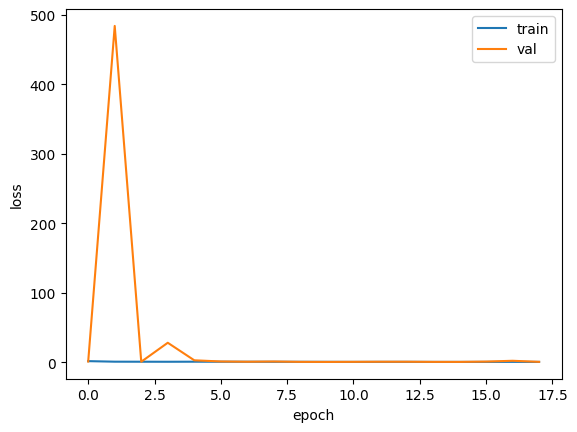

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [10]:
model.evaluate(val_gen, steps=val_image_cnt//BATCH_SIZE)

38/38 [==============================] - 3s 77ms/step - loss: 0.3367 - accuracy: 0.8553


[0.336736261844635, 0.8552631735801697]

In [11]:
save_name = 'model_weights_' + MODEL +'.h5'
model.save_weights(save_name)

In [12]:
model_json = model.to_json()
save_name = 'model_' + MODEL +'.json'
with open(save_name, 'w') as json_file : 
    json_file.write(model_json)

In [14]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('files/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=IMAGE_SHAPE)

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

ModuleNotFoundError: No module named 'cv2'

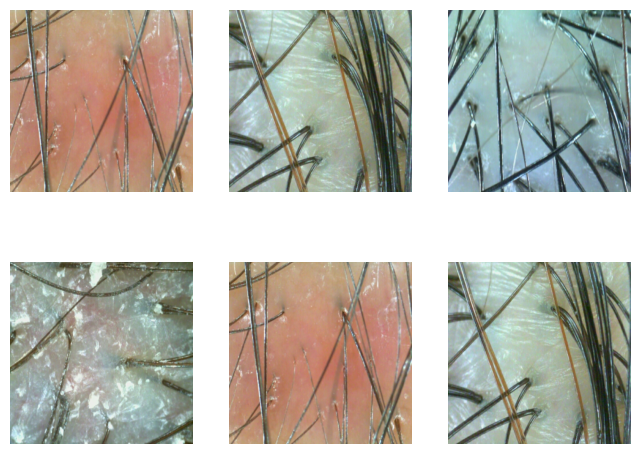

In [16]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):

    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [21]:
class_name = ['normal','hair_loss']  # ImageDataGenerator 에서

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

(6, 2)
[[2.3693973e-03 9.9763060e-01]
 [9.9990702e-01 9.2958078e-05]
 [9.9775261e-01 2.2474013e-03]
 [1.6795741e-01 8.3204263e-01]
 [2.3693973e-03 9.9763060e-01]
 [9.9990702e-01 9.2958078e-05]]


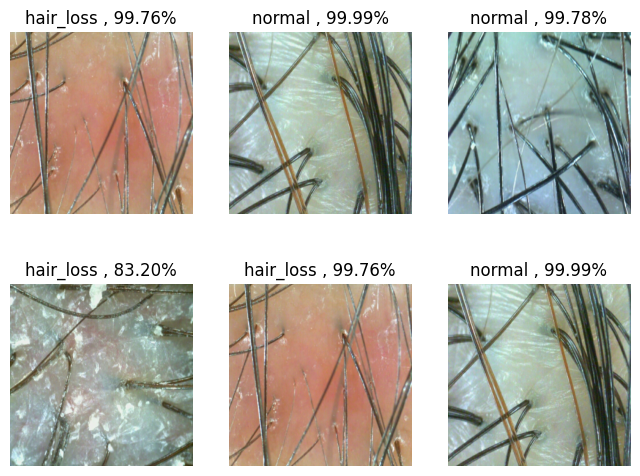

In [22]:
plt.figure(figsize=(8,6))

for i in range(len(pred)):

    plt.subplot(2, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()